<font color = 'Orange' size = 6> Satellite Dataset-RSI-CB256 trained with VGG16 Architecture</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
helper_methods_folder = '/content/drive/MyDrive/AI Project/Model Training/helper_methods'

sys.path.append(os.path.abspath(helper_methods_folder))

**Importing helper methods for preprocessing, training and plotting**

In [ ]:
from preprocessing import load_data
from plots import plot_data_loader, show_examples
from plots import plot_accuracy, plot_loss,plot_training_batch_loss, plot_confusion_matrix
from training import train_model, compute_accuracy_and_loss
from early_stopping import EarlyStopping
from metrics import compute_classification_report, compute_confusion_matrix
from unnormalize_images import UnNormalize
from predictions import predict_image_class

**Importing Libraries**

In [ ]:
from torchvision import models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt


In [ ]:
root_dir = r'/content/drive/MyDrive/AI Project/Datasets/Satellite Dataset-RSI-CB256/data'
path_to_save_model=r"/content/drive/MyDrive/AI Project/Model Training/Satellite_datatset_weights/"
file_name = "satellite_dataset"

**Load the datasets into train_loader, validation loader and test loader**

In [ ]:
train_loader, test_loader, valid_loader, data = load_data(root_dir, test_split=0.3, val_split=0.1, batch_size=32, input_size=[64,64])

In [ ]:
# checking the train loader dataset information
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([3, 3, 0, 3, 3, 0, 2, 3, 1, 0])


**Encodings for the classes**

In [ ]:
label_encoding = data.class_to_idx  
print("label mapping is ", label_encoding)   # save these mapping for predicition  

label mapping is  {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


**Plot the data loader**

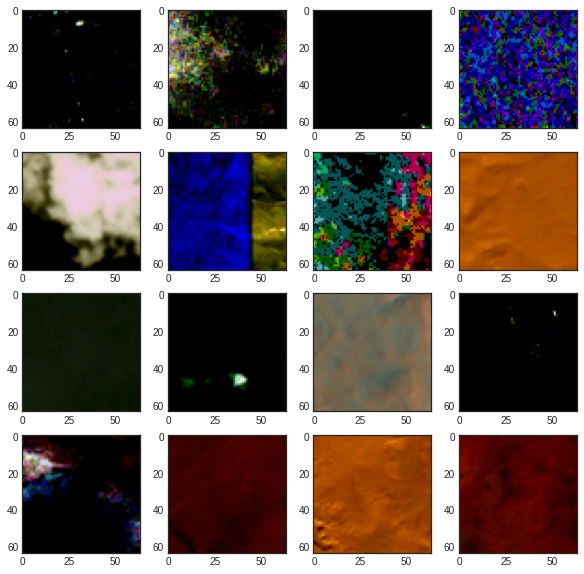

In [ ]:
plot_data_loader(train_loader, (4,4))

**Load VGG16 Model with Batch Normalization** 

In [ ]:
model = models.vgg16_bn()  # By default, no pre-trained weights are used.
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

**Change the number of outputs classes in the last layer of the model**

In [ ]:
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)  #num_classes = 4
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

**Set the hyperparameters**

In [ ]:
# define the loss function for multi-class classifictaion
criterion = nn.CrossEntropyLoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001,  amsgrad=False)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, verbose=False)

# create and early stopping object which will be used during the training
early_stopping = EarlyStopping(tolerance=3, min_delta=0.01)

num_epochs = 30

**Train the Model with train_loader and perform validation with valid_loader**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

model.to(device)

minibatch_loss_list, train_acc_list, valid_acc_list, train_loss_list, valid_loss_list = train_model(
    model=model,
    num_epochs=num_epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion = criterion,
    optimizer=optimizer,
    device=device,
    early_stopping=early_stopping,
    file_name = file_name,
    path_to_save_model=path_to_save_model,
    scheduler=scheduler)

Device: cuda:0
Epoch: 001/030 | Batch 0000/0106 | Loss: 1.5380
Epoch: 001/030 | Batch 0100/0106 | Loss: 1.2768
Epoch: 001/030 | Train ACC: 29.69% | Validation ACC: 34.46%| Train LOSS: 4.0344| Validation LOSS: 0.0402
Time elapsed: 14.84 min
Epoch: 002/030 | Batch 0000/0106 | Loss: 1.1373
Epoch: 002/030 | Batch 0100/0106 | Loss: 1.2583
Epoch: 002/030 | Train ACC: 37.50% | Validation ACC: 34.99%| Train LOSS: 1.3224| Validation LOSS: 0.0435
Time elapsed: 15.21 min
Epoch: 003/030 | Batch 0000/0106 | Loss: 1.2643
Epoch: 003/030 | Batch 0100/0106 | Loss: 1.1266
Epoch: 003/030 | Train ACC: 39.06% | Validation ACC: 36.41%| Train LOSS: 1.2978| Validation LOSS: 0.0398
Time elapsed: 15.59 min
Saving intermediate model weights 
Epoch: 004/030 | Batch 0000/0106 | Loss: 1.3153
Epoch: 004/030 | Batch 0100/0106 | Loss: 1.3723
Epoch: 004/030 | Train ACC: 32.81% | Validation ACC: 34.46%| Train LOSS: 1.2615| Validation LOSS: 0.0411
Time elapsed: 16.09 min
Epoch: 005/030 | Batch 0000/0106 | Loss: 1.2423
Ep

**Test Accuracy and test loss**

In [ ]:
test_acc, test_loss= compute_accuracy_and_loss(model, test_loader,criterion, device=device)
print(f'Test Accuracy {test_acc :.2f}%')
print(f'Test Loss {test_loss :.4f}')

Test Accuracy 54.35%
Test Loss 0.0329


**Plot the Training Mini_Batch_loss**

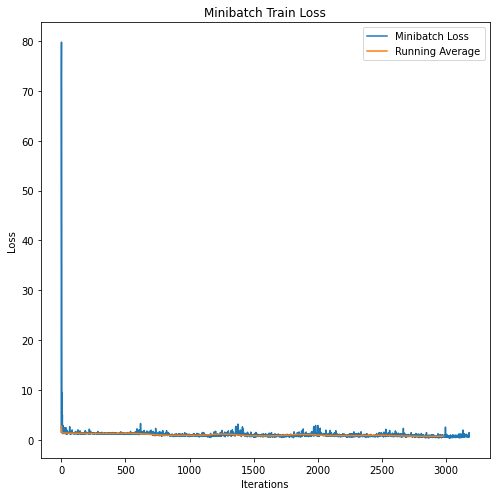

In [ ]:
plot_training_batch_loss(minibatch_loss_list, num_epochs, len(train_loader))
plt.show()

**Plot train vs Validation Accuracy**

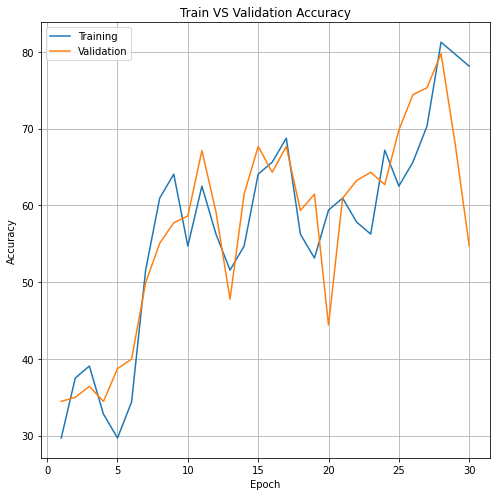

In [ ]:
plot_accuracy(train_acc_list, valid_acc_list)
plt.show()

**Plot train vs Validation Loss**

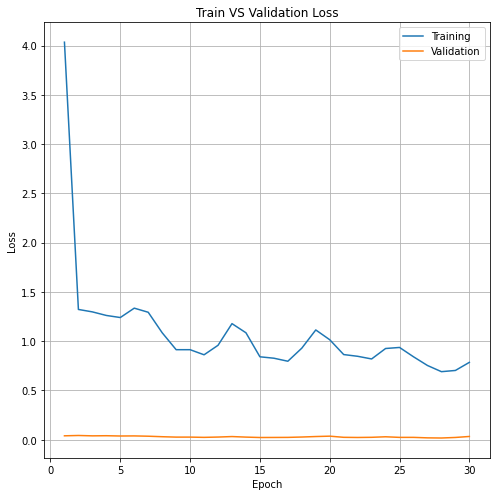

In [ ]:
plot_loss(train_loss_list, valid_loss_list)
plt.show()

**Saving the loss and accuracy into file for later model comparison**

In [ ]:
satellite_dataset_output_dict = {"train_acc_list":train_acc_list,"valid_acc_list":valid_acc_list, "train_loss_list":train_loss_list, "valid_loss_list": valid_loss_list}

import json 

#writing this dict to a file for later use
with open('./Satellite_dataset_results.txt', 'w') as f:
    f.write(json.dumps(satellite_dataset_output_dict))


# for reading the file back into a Python object
# with open('./Satellite_dataset_results.txt, 'r') as f:
#     satellite_dataset_output_dict = json.loads(f.read())

**Confusion Matrix**

In [ ]:
label_encoding = data.class_to_idx

class_dict = {v: k for k, v in label_encoding.items()} #reverse the mapping

print(label_encoding)

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


In [ ]:
# label_encoding = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}  # assign to a variable as it will be needed while prediciting

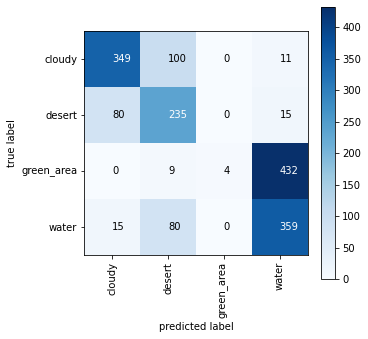

In [ ]:
confusion_matrix = compute_confusion_matrix(model = model, data_loader = test_loader, device=torch.device('cuda'))
plot_confusion_matrix(confusion_matrix, class_names = class_dict.values())
plt.show()

**F1 Score, Precision and Recall**

In [ ]:
print(compute_classification_report(test_loader, model, device=torch.device('cuda') ))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       458
           1       0.72      0.55      0.62       433
           2       0.00      1.00      0.00         1
           3       0.74      0.42      0.54       797

    accuracy                           0.56      1689
   macro avg       0.56      0.69      0.49      1689
weighted avg       0.75      0.56      0.63      1689



**Predicted labels Visualization**

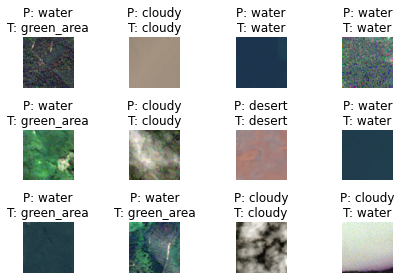

In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

**Load the saved model to make predictions**

In [ ]:
model  = torch.load(path_to_save_model + file_name+'_14_Intermdiate_MODEL_WEIGHTS2.pth', map_location=torch.device('cpu'))

In [ ]:
# test image path 
img_path = '/content/drive/MyDrive/AI Project/Model Training/test_images/water_body_1011.jpg'

In [ ]:
classes = ['cloudy','desert','green_area','water']
print("The predicted class is " , predict_image_class(model, img_path, classes))

The predicted class is  green_area
